# Prediction de la date de saturation des hôpitaux

Import des dataset

**Source :**
* Report of the WHO-China Joint Mission
on Coronavirus Disease 2019 : https://www.who.int/docs/default-source/coronaviruse/who-china-joint-mission-on-covid-19-final-report.pdf
* Care for Critically Ill Patients With COVID-19 : https://jamanetwork.com/journals/jama/fullarticle/2762996
* Daily time series : https://github.com/opencovid19-fr/data
CSSE at Johns Hopkins University : https://github.com/CSSEGISandData/COVID-19


In [31]:
import numpy as np
import re
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)
%matplotlib inline

## Analyse de l'évolution des cas de COVID19 la France vs le reste du monde

In [32]:
ts_confirmed = pd.read_csv("Data/time_series_covid_19_confirmed.csv")
ts_confirmed_new = pd.read_csv("Data/time_series/time_series_19-covid-Confirmed.csv")

In [204]:
ts_confirmed_new[ts_confirmed_new["Country/Region"] == "France"]

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,2/20/20,2/21/20,2/22/20,2/23/20,2/24/20,2/25/20,2/26/20,2/27/20,2/28/20,2/29/20,3/1/20,3/2/20,3/3/20,3/4/20,3/5/20,3/6/20,3/7/20,3/8/20,3/9/20,3/10/20,3/11/20,3/12/20,3/13/20,3/14/20,3/15/20,3/16/20
157,France,France,46.2276,2.2137,0,0,2,3,3,3,4,5,5,5,6,6,6,6,6,6,6,11,11,11,11,11,11,11,12,12,12,12,12,12,12,12,12,12,14,18,38,57,100,130,191,204,285,377,653,949,1126,1209,1784,2281,2281,3661,4469,4499,6633
198,St Martin,France,18.0708,-63.0501,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,2,2,2,2,2,2,2
205,Saint Barthelemy,France,17.9000,-62.8333,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,3,3,3,3,1,1,1,1,1,1,1,3
406,French Polynesia,France,-17.6797,149.4068,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,3,3,3
436,French Guiana,France,3.9339,-53.1258,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5,5,5,5,5,5,5,5,7,5
444,Mayotte,France,-12.8275,45.1662,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1
449,Guadeloupe,France,16.2500,-61.5833,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3


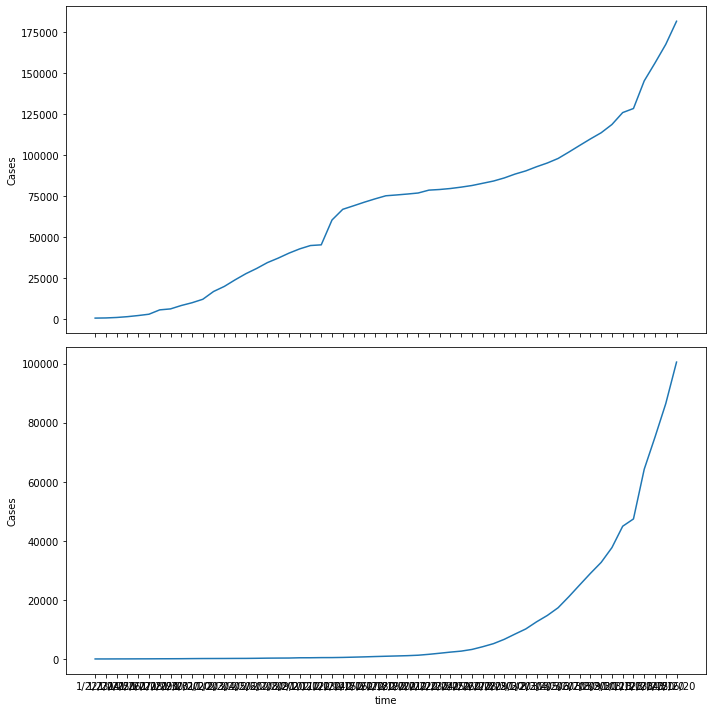

In [34]:
fig, axs = plt.subplots(2, 1, sharex=True, figsize=(10, 10))

axs[0].plot(ts_confirmed_new.sum()[2:])
axs[0].set_ylabel("Cases")
axs[1].set_ylabel("Cases")
axs[1].set_xlabel("time")
#axs[1].grid(True)
#axs[1].set_yscale("log")
#axs[0].set_yscale("log")

axs[1].plot(ts_confirmed_new[ts_confirmed_new["Country/Region"] != "China"].sum()[2:])
fig.tight_layout()

On remarque clairement que nous le reste du monde entre dans la phase exponentiel

## Construction des series temporels des cas confirmés 

In [206]:
f_confirmed = ts_confirmed_new[ts_confirmed_new["Country/Region"] == "France"].iloc[0][4:]

i_confirmed = ts_confirmed_new[ts_confirmed_new["Country/Region"] == "Italy"].sum(axis=0)[4:]

c_confirmed = ts_confirmed_new[ts_confirmed_new["Country/Region"] == "Mainland China"].sum(
    axis=0
)[4:]
sg_confirmed = ts_confirmed_new[ts_confirmed_new["Country/Region"] == "Singapore"].sum(axis=0)[
    4:
]
ger_confirmed = ts_confirmed_new[ts_confirmed_new["Country/Region"] == "Germany"].sum(axis=0)[
    4:
]
sp_confirmed = ts_confirmed_new[ts_confirmed_new["Country/Region"] == "Spain"].sum(axis=0)[
    4:
]
skorea_confirmed =ts_confirmed_new[ts_confirmed_new["Country/Region"] == "Korea, South"].sum(axis=0)[
    4:
]

taiwan_confirmed =ts_confirmed_new[ts_confirmed_new["Country/Region"] == "Taiwan*"].sum(axis=0)[
    4:
]

f_confirmed.index = pd.to_datetime(f_confirmed.index)
i_confirmed.index = pd.to_datetime(i_confirmed.index)
c_confirmed.index = pd.to_datetime(c_confirmed.index)
sg_confirmed.index = pd.to_datetime(sg_confirmed.index)
sp_confirmed.index = pd.to_datetime(sp_confirmed.index)
ger_confirmed.index = pd.to_datetime(ger_confirmed.index)
skorea_confirmed.index = pd.to_datetime(skorea_confirmed.index)
taiwan_confirmed.index = pd.to_datetime(taiwan_confirmed.index)

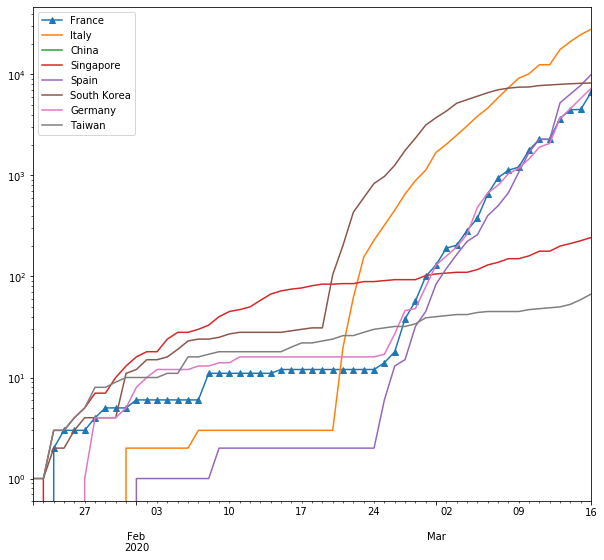

In [207]:
fig = plt.figure(figsize=(10, 20))
ax = fig.add_subplot(2, 1, 1)
ax.set_yscale("log")

f_confirmed.plot(label="France",marker='^')
i_confirmed.plot(label="Italy")
c_confirmed.plot(label="China")
sg_confirmed.plot(label="Singapore")
sp_confirmed.plot(label="Spain")
skorea_confirmed.plot(label="South Korea")
ger_confirmed.plot(label="Germany")
taiwan_confirmed.plot(label="Taiwan")

plt.legend(loc="best")

## Facteur de changement

Le facteur de changement de la courbe est égale au ratio de nouvzaux cas détéctés entredeux jours. Autrement dit, c'est le ratio de la différence de nombres de cas détectés entre deux jours successifs

In [208]:
def growth(serie):
    g = []
    index = []
    for i in range(len(f_confirmed) - 2):
        if serie.diff()[i] == 0:
            g.append(0)
        else:
            g.append(serie.diff()[i + 1] / serie.diff()[i])
        index.append(serie.index[i])
    return pd.Series(data=g, index=index).replace([np.inf, -np.inf], np.nan).fillna(0)

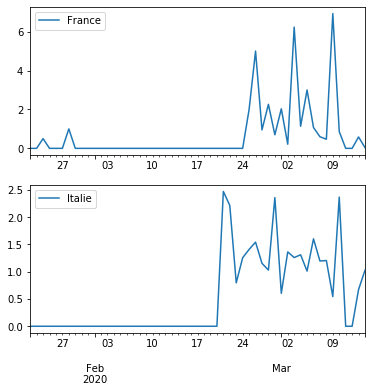

In [209]:
fig, ax = plt.subplots(2,1,figsize=(6, 6))

growth(f_confirmed).plot(ax=ax[0],label="France")
growth(i_confirmed).plot(ax=ax[1],label="Italie")

# growth(c_confirmed).pct_change().plot(label='China')
#growth(sg_confirmed).pct_change().plot(label="Singapore")

ax[0].legend(loc="best")
ax[1].legend(loc="best")

## Ratio du changement

In [210]:
def ratio_change(serie):
    g = []
    index = []
    for i in range(len(serie) - 1):
        if i == 0:
            g.append(1)
        else:
            g.append(serie[i] / serie[i-1])
        index.append(serie.index[i])
    return pd.Series(data=g, index=index).replace([np.inf, -np.inf], np.nan).fillna(0)

count    46.000000
mean      1.163065
std       0.082811
min       1.000000
25%       1.111474
50%       1.164075
75%       1.215699
max       1.355129
dtype: float64


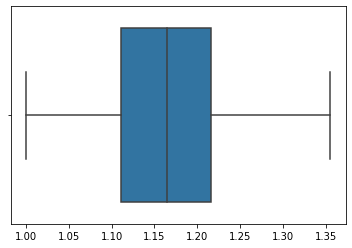

In [211]:
sns.boxplot(ratio_change(ts_confirmed_new[ts_confirmed_new["Country/Region"] != "China"].sum()[10:]))
print(ratio_change(ts_confirmed_new[ts_confirmed_new["Country/Region"] != "China"].sum()[10:]).describe())

count    44.000000
mean      1.189440
std       0.279720
min       1.000000
25%       1.000000
50%       1.000000
75%       1.304861
max       2.111111
dtype: float64


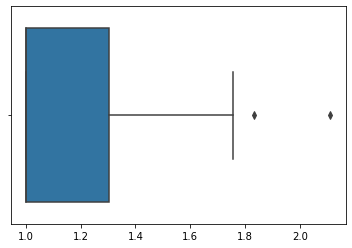

In [212]:
sns.boxplot(ratio_change(f_confirmed_new[10:]))
print(ratio_change(f_confirmed_new[10:]).describe())

Nous remarquons un ratio de changement variant de 1.16 à 1.22 dans le monde, un ratio de 1.18 en moyenne en France avec une plus grance variance(0.27)

Ceci s'explique par le manque de tests généralisés en France.

## Temps pour doubler 

In [322]:
dates=[]
serie=ts_confirmed_new[ts_confirmed_new["Country/Region"] != "China"].sum()[2:]
serie.index = pd.to_datetime(serie.index)
for i in range(len(serie)-1):
    j=i
    while  (serie[j] < 2*serie[i]) & (j< len(serie)-1):        
        j=j+1 
    if j>i+1 :
        dates.append(serie.index[j]-serie.index[i])


In [324]:
print('Moyenne pour doubler le chiffre est de ',np.mean(dates))

Moyenne pour doubler le chiffre est de  4 days 23:04:36.923076


## Décaler les courbes au même début

Décaler la courbe des cas de france et d'italie

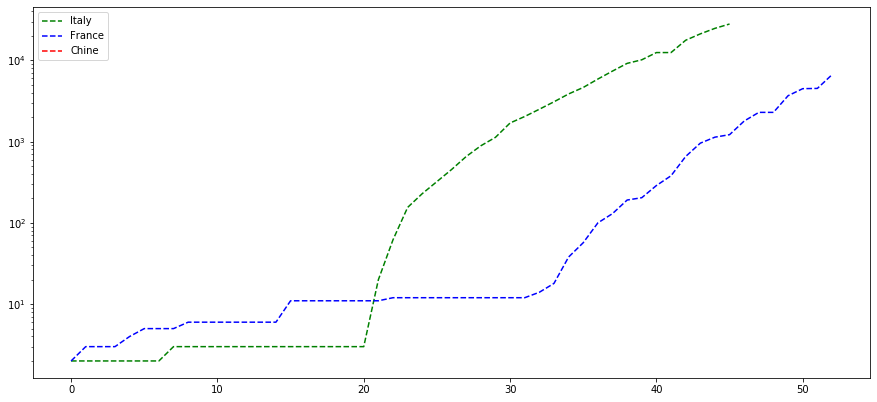

In [39]:
ilist = i_confirmed.where(i_confirmed > 0).dropna().tolist()
flist = f_confirmed.where(f_confirmed > 0).dropna().tolist()
Clist = c_confirmed.where(c_confirmed > 0).dropna().tolist()


fig = plt.figure(figsize=(15, 15))
ax = fig.add_subplot(2, 1, 1)
ax.set_yscale("log")
ax.plot(ilist, "g--", label="Italy")
ax.plot(flist, "b--", label="France")
ax.plot(Clist, "r--", label="Chine")
plt.legend(loc="upper left")

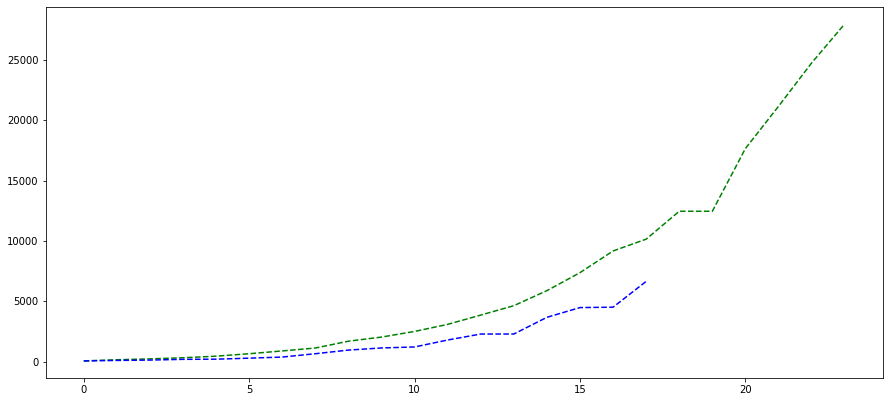

In [40]:
ilist=i_confirmed.where(i_confirmed > 30).dropna().tolist()
flist=f_confirmed.where(f_confirmed > 40).dropna().tolist()

fig = plt.figure(figsize=(15, 15))
ax = fig.add_subplot(2, 1, 1)
#ax.set_yscale("log")
ax.plot(ilist, "g--", label="Italy")
ax.plot(flist, "b--", label="France")

## Remarques


En décalant les deux courbes pour avoir le même début, nous remarquons que les courbes ont la même forme exponentiel, la France a pu retarder l'évolution des cas de COVID19 un peu plus longtemps de l'Italie mais la progression du virus est visuellement la même;

**Comme annoncé par le président de la république Macron, l'épidémie en France ne fait que commencer.**

# LSTM trained on french data

In [41]:
import math
from datetime import timedelta
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error

## Preparing the data

In [122]:
# split a univariate sequence into samples
def split_sequence(sequence, n_steps):
    X, y = list(), list()
    for i in range(len(sequence)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the sequence
        if end_ix > len(sequence) - 1:
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return np.asarray(X), np.asarray(y)

The training data will be the france confirmed cases till 11 march 2020 

In [123]:
f_confirmed =ts_confirmed[ts_confirmed["Country/Region"] == "France"].sum(axis=0)[10:]
f_confirmed.index = pd.to_datetime(f_confirmed.index)

In [124]:
# define input sequence
# choose a number of time steps ( equivalent to # of features)
n_steps = 4

X, y = split_sequence(f_confirmed, n_steps)

## LSTM Model

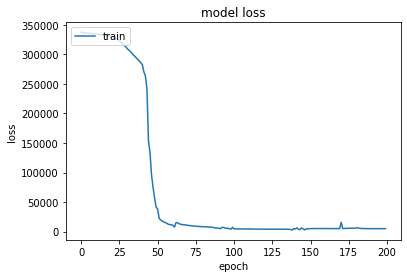

In [125]:
n_features = 1

X = X.reshape((X.shape[0], X.shape[1], n_features))

# define model
model = Sequential()
model.add(LSTM(10, activation="relu", input_shape=(n_steps, n_features)))
model.add(Dense(1))
model.compile(optimizer="adam", loss="mse")


# fit model
history = model.fit(X, y, epochs=200, verbose=0)

# history for loss
plt.plot(history.history["loss"])
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "test"], loc="upper left")
plt.show()

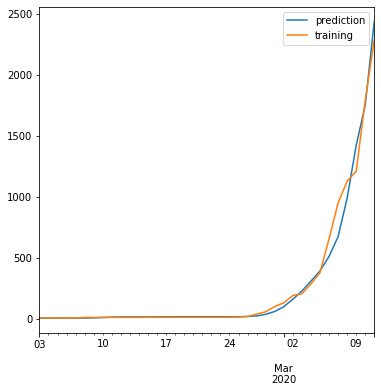

In [158]:
fig, ax = plt.subplots(1,1,figsize=(6, 6))

pred = model.predict(X)
pred_serie =pd.Series(data=pred.flatten(),index=f_confirmed[4:].index)

pred_serie.plot(ax=ax,label='prediction')
f_confirmed[4:].plot(ax=ax,label='training')

ax.legend(loc="best")


## Prediction

Prédire l'évoltion des cas de COVID19 en France sur le prochains 30 jours

In [126]:
n = 30
index30 = pd.date_range(f_confirmed.index[-1] + timedelta(days=1), periods=n, freq="D")
last_values = f_confirmed[-n_steps:].values
prediction30 = []

In [127]:
for i in range(n):
    x_input = last_values[-n_steps:]
    x_input = x_input.reshape((1, n_steps, n_features))
    y_pred = model.predict(x_input)
    prediction30.append(int(y_pred[0][0]))
    last_values = np.append(last_values, int(y_pred[0][0]))

serie30_france = pd.Series(data=prediction30, index=index30)

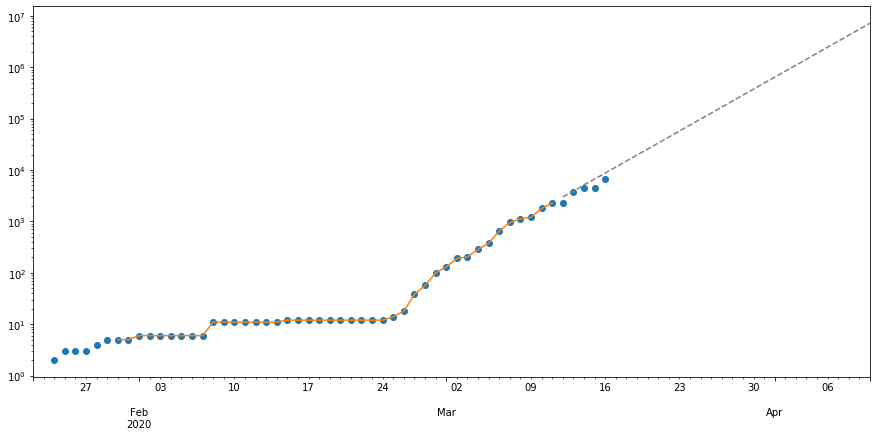

In [128]:
fig = plt.figure(figsize=(15, 15))
ax = fig.add_subplot(2, 1, 1)


ax.set_yscale('log')

f_confirmed_new = ts_confirmed_new[ts_confirmed_new["Country/Region"] == "France"].sum(axis=0)[4:]
f_confirmed_new.index = pd.to_datetime(f_confirmed_new.index)



f_confirmed_new.plot(ax=ax, label="france_new",marker='o',linestyle='')
f_confirmed.plot(ax=ax, label="france")
#c_confirmed.plot(ax=ax, c="red", label="China")

serie30_france.plot(ax=ax, c="grey", linestyle="--", label="predition for 30 days")

## Intégrer logistique

In [189]:
N_total_france = 67000000 #67000000

Incluiiding a rate of decay of cases of : 1 - Ncase/Ntotal

In [190]:
def logistique (serie):
    g = []
    index = []
    for i in range(len(serie)-1):
        if i == 0:
            g.append(serie[i])
        else:
            g.append(int(serie[i] - (serie[i]/serie[i-1])*((serie[i-1]**2)/N_total_france)))
        index.append(serie.index[i])
    return pd.Series(data=g, index=index).replace([np.inf, -np.inf], np.nan).fillna(0)

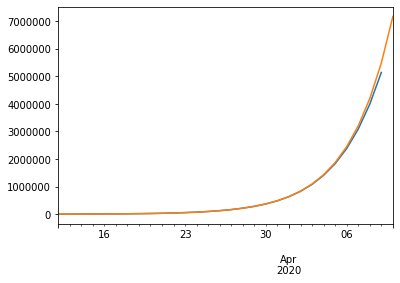

In [191]:
logistique(serie30_france).plot()
serie30_france.plot()

# LSTM used for South korea

## Prepare train data

In [49]:
# define input sequence
# choose a number of time steps ( equivalent to # of features)
n_steps = 3

X, y = split_sequence(skorea_confirmed[:-1], n_steps)

n_features = 1

# scaler = StandardScaler()
# trainX = scaler.fit_transform(X)
#
# trainX = trainX.reshape((trainX.shape[0], trainX.shape[1], n_features))

X = X.reshape((X.shape[0], X.shape[1], n_features))

## Define model

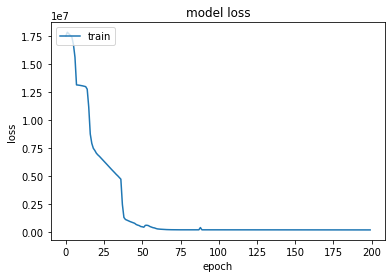

In [50]:
# define model
model = Sequential()
model.add(LSTM(10, activation="relu", input_shape=(n_steps, n_features)))
model.add(Dense(1))
model.compile(optimizer="adam", loss="mse")


# fit model
history = model.fit(X, y, epochs=200, verbose=0)

# history for loss
plt.plot(history.history["loss"])
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "test"], loc="upper left")
plt.show()

## Prediction

In [51]:
n = 100
index30 = pd.date_range(f_confirmed.index[-1] + timedelta(days=1), periods=n, freq="D")
last_values = f_confirmed[-n_steps:].values
prediction30 = []


for i in range(n):
    x_input = last_values[-n_steps:]
    x_input = x_input.reshape((1, n_steps))
    x_input = x_input.reshape((1, n_steps, n_features))
    y_pred = model.predict(x_input)
    prediction30.append(int(y_pred[0][0]))
    last_values = np.append(last_values, int(y_pred[0][0]))

serie30 = pd.Series(data=prediction30, index=index30)


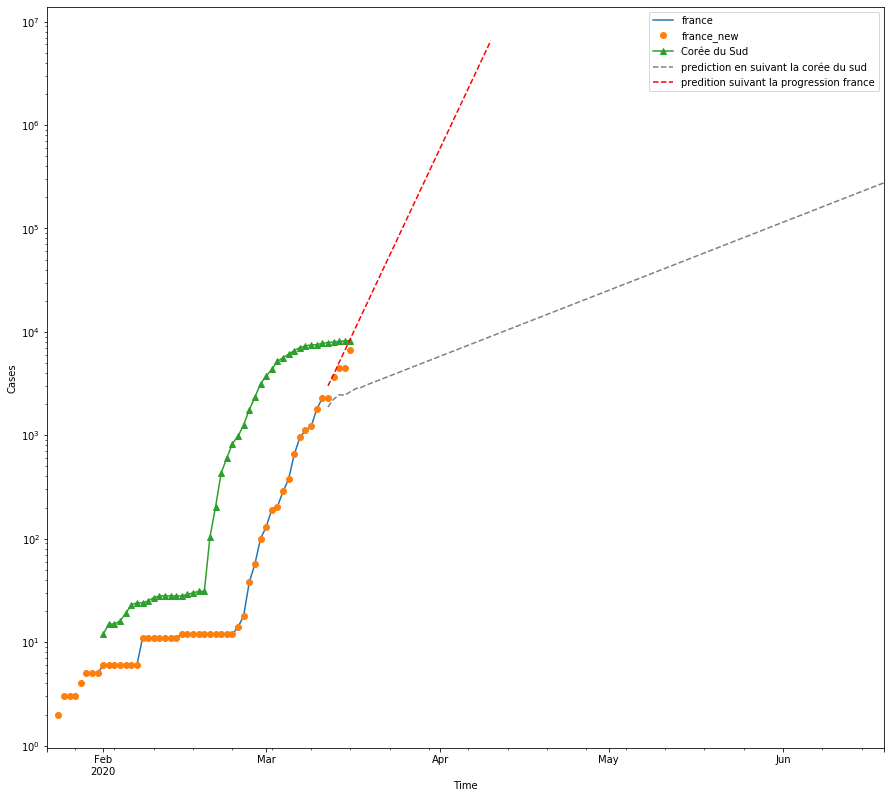

In [118]:
fig = plt.figure(figsize=(15, 30))
ax = fig.add_subplot(2, 1, 1)

ax.set_yscale("log")

f_confirmed.plot(ax=ax, label="france")
f_confirmed_new.plot(ax=ax, label="france_new",marker='o',linestyle='')
skorea_confirmed[10:].plot(ax=ax, marker='^', label="Corée du Sud")

serie30.plot(ax=ax, c="grey", linestyle="--", label="prediction en suivant la corée du sud")


serie30_france.plot(ax=ax, c="red", linestyle="--", label="predition suivant la progression france")


ax.set_xlabel("Time")
ax.set_ylabel("Cases")
ax.legend(loc='best')


## Saturation des lits de réanimation dans les hôpitaux

Sachant que la france dispose de 5000 lits sur le territoire et que 5% des cas contaminés par le COVID19 nécessitent un prise en charge hospitalière critique (source : https://jamanetwork.com/journals/jama/fullarticle/2762996).

**Le recours au secteur privé** 
À la demande du gouvernement, le secteur privé, jusque-là en dehors du dispositif, a lui aussi été sollicité. « Dans les premiers temps de l’épidémie, les centres hospitaliers universitaires étaient référents dans la prise en charge. Quand un cas suspect se présentait dans un établissement privé, il était mis en sécurité et à l’isolement pour protéger les patients, puis redirigé vers un CHU pour être soigné », explique Lamine Gharbi, président de la Fédération de l’hospitalisation privée (FHP). Mais on est prêt depuis des semaines, et apportons 4 000 lits disponibles sur le territoire. 

Ce qui nous fait un total 9000 lits

In [53]:
hosp = f_confirmed_new.apply(lambda x :x*0.05)
hosp_france = serie30_france.apply(lambda x :x*0.05)
hosp_ks = serie30.apply(lambda x :x*0.05)

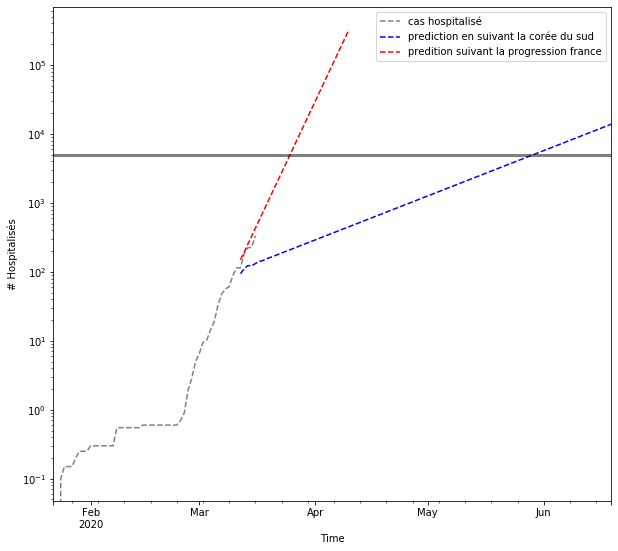

In [54]:
fig = plt.figure(figsize=(10, 20))
ax = fig.add_subplot(2, 1, 1)
ax.set_yscale('log')

hosp.plot(ax=ax, c="grey", linestyle="--", label="cas hospitalisé")
hosp_ks.plot(ax=ax, c="blue", linestyle="--", label="prediction en suivant la corée du sud")
hosp_france.plot(ax=ax, c="red", linestyle="--", label="predition suivant la progression france")

ax.set_ylabel("# Hospitalisés")
ax.set_xlabel("Time")
ax.legend(loc='best')
ax.axhline(y=5000,linewidth=3, color='black',alpha=0.5)

In [55]:
print('Date de saturation du système hospitalien Francais dans le pire scénario :'+hosp_france.where(hosp_france>=5000).dropna().index[0].strftime("%d/%m/%Y"))
print('Date de saturation du système hospitalien Francais dans le meilleur scénario :'+hosp_ks.where(hosp_ks>=5000).dropna().index[0].strftime("%d/%m/%Y"))

Date de saturation du système hospitalien Francais dans le pire scénario :26/03/2020
Date de saturation du système hospitalien Francais dans le meilleur scénario :30/05/2020
